In [2]:
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np
import pprint
import pandas as pd
from sklearn.svm import LinearSVC
from sklearn.model_selection import train_test_split, KFold, cross_validate
from sklearn.naive_bayes import BernoulliNB, ComplementNB, MultinomialNB
from sklearn.metrics import accuracy_score, f1_score, make_scorer, precision_score, recall_score
from sklearn import preprocessing
from sklearn.feature_extraction.text import CountVectorizer
import advertools as adv
from matplotlib import pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import cross_val_score,  cross_val_predict
import seaborn as sns
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler, SMOTE
pp = pprint.PrettyPrinter(indent=4, sort_dicts=False)


In [3]:
train_data = pd.read_csv("../corpus/nolang_dif/train_data.csv")
print(train_data.head())


test_data = pd.read_csv("../corpus/nolang_dif/test_data.csv")
print(test_data.head())


   index language                                               text    label
0      0       da  Dette er et fremragende initiativ, og jeg støt...  Ireland
1      1       da  Hr. formand, jeg er sikker på, at alle her er ...  Ireland
2      2       da  Hr. formand, folk på den nordlige halvkugle tr...  England
3      3       da  Hr. formand, med forbehold af nogle få ændring...  England
4      4       da  Hr. formand, jeg må protestere mod den lemfæld...  England
   index                                               text language
0      0  Hr. formand, selv om vi i høj grad sympatisere...       da
1      1  Quiero dejar constancia de mi apoyo a este inf...       es
2      2  – El comercio ilegal de riñones humanos se ha ...       es
3      3  Signor Presidente, per introdurre una nota di ...       it
4      4  Jeg stemte for meddelelsen af decharge til fæl...       da


In [4]:
kfold = KFold(n_splits=5, shuffle=True, random_state=21)
model = LinearSVC(max_iter=5000, random_state=21, C=1,  penalty="l1", dual=False, class_weight="balanced")

stop_words = []
for key in ["danish", "german", "dutch", "italian", "spanish"]:
    stop_words += list(adv.stopwords[key])
tfidf = TfidfVectorizer(sublinear_tf=True, norm='l2', ngram_range=(1, 2), stop_words=stop_words)

def simpleModel(X_train, y_train, X_test):
    print(f"Train size: {len(X_train)}, Test size: {len(X_test)}")
    X = tfidf.fit_transform(list(X_train) + list(X_test))
    model.fit(X[:len(X_train)], y_train)
    res = model.predict(X[len(X_train):])
    return res


In [5]:
predicted_labels = simpleModel(train_data.text, train_data.label, test_data.text)

Train size: 41568, Test size: 13860


In [6]:
final_data = {"id": test_data.index+1, "label": predicted_labels}

submission = pd.DataFrame(data=final_data).set_index("id")
submission.head()
submission.to_csv(f"../submissions/nolang_SVM_tf-idf.csv")


In [7]:
acc = []
f1 = []
predicted = []
actual = []

features = np.array(train_data.text).reshape(-1, 1)
labels = np.array(train_data.label)


kfold_train = pd.DataFrame({"text": features.flatten(), "label":labels})
for train_index, test_index in kfold.split(kfold_train):
    X_train, X_test = kfold_train.text[train_index], kfold_train.text[test_index]
    y_train, y_test = list(kfold_train.label[train_index]), list(kfold_train.label[test_index])

    res = simpleModel(X_train, y_train, X_test)
    predicted.extend(res)
    actual.extend(y_test)

    acc.append(accuracy_score(res, y_test))
    f1.append(f1_score(res, y_test, average="weighted"))

Train size: 33254, Test size: 8314
Train size: 33254, Test size: 8314
Train size: 33254, Test size: 8314
Train size: 33255, Test size: 8313
Train size: 33255, Test size: 8313


[0.7315371662256435, 0.736949723358191, 0.7450084195333173, 0.7490677252496091, 0.7347527968242512]
Acc: 0.7394631662382024
[0.7351055091005869, 0.7413615773266499, 0.7486433249968426, 0.7527425854428922, 0.7373999706184309]
F1: 0.7430505934970805


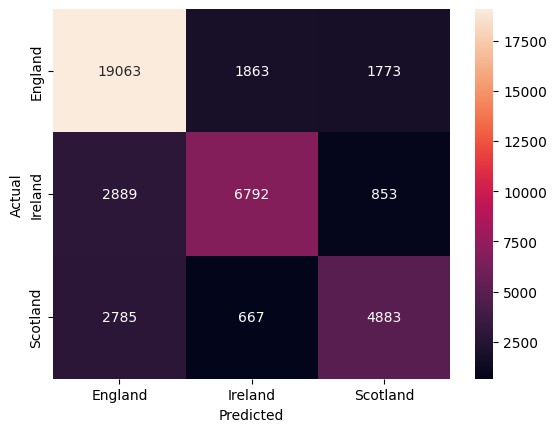

In [9]:
print(acc)
print("Acc:", np.array(acc).mean())
print(f1)
print("F1:", np.array(f1).mean())
label_vals = ["England", "Ireland", "Scotland"]
conf_mat = confusion_matrix(actual, predicted)
sns.heatmap(conf_mat, annot=True, fmt='d',
            xticklabels=label_vals, yticklabels=label_vals)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()
